# ZEC branching experiments with fair

- fair v2.2.2
- calibration v1.4.0
- run CO2-only
- ssp245, ssp370, ssp585
- ZEC every 5 years from 1950 to 2100, run to 2500

In [1]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm

import fair
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [2]:
fair.__version__

'2.2.2'

In [3]:
fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv'

In [4]:
scenarios = ['ssp245', 'ssp370', 'ssp585']

In [5]:
species = ['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O']
properties = {
    "CO2 FFI": {
        'type': 'co2 ffi',
        'input_mode': 'emissions',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CO2 AFOLU": {
        'type': 'co2 afolu',
        'input_mode': 'emissions',
        'greenhouse_gas': False,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CO2": {
        'type': 'co2',
        'input_mode': 'calculated',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CH4": {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "N2O": {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    }
}

In [7]:
f = {}
for zero_year in tqdm(np.arange(1950, 2101, 5, dtype=int)):
    f[zero_year] = FAIR(ch4_method='Thornhill2021')
    f[zero_year].define_time(1750, 2500, 1)
    f[zero_year].define_scenarios(scenarios)
    df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)
    configs = df_configs.index  # label for the "config" axis
    f[zero_year].define_configs(configs)
    f[zero_year].define_species(species, properties)
    f[zero_year].allocate()
    f[zero_year].fill_from_rcmip()

    f[zero_year].fill_species_configs()

    # set CH4 and N2O to zero. they are only here to give us something to use for the ERF
    fill(f[zero_year].emissions, 0, specie='CH4')
    fill(f[zero_year].emissions, 0, specie='N2O')

    # set CO2 emissions to zero after a certain year
    fill(f[zero_year].emissions, 0, specie='CO2 FFI', timepoints=np.arange(zero_year+0.5, 2500))
    fill(f[zero_year].emissions, 0, specie='CO2 AFOLU', timepoints=np.arange(zero_year+0.5, 2500))
    
    f[zero_year].fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0.csv")
    f[zero_year].override_defaults("../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv")
    fill(f[zero_year].climate_configs['stochastic_run'], False)

    # set initial conditions
    initialise(f[zero_year].concentration, f[zero_year].species_configs['baseline_concentration'])
    initialise(f[zero_year].forcing, 0)
    initialise(f[zero_year].temperature, 0)
    initialise(f[zero_year].airborne_emissions, 0)
    initialise(f[zero_year].cumulative_emissions, 0)

    f[zero_year].run(progress=False)

  0%|          | 0/31 [00:00<?, ?it/s]

In [12]:
zero_year='none'
f[zero_year] = FAIR(ch4_method='Thornhill2021')
f[zero_year].define_time(1750, 2500, 1)
f[zero_year].define_scenarios(scenarios)
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)
configs = df_configs.index  # label for the "config" axis
f[zero_year].define_configs(configs)
f[zero_year].define_species(species, properties)
f[zero_year].allocate()
f[zero_year].fill_from_rcmip()

f[zero_year].fill_species_configs()

# set CH4 and N2O to zero. they are only here to give us something to use for the ERF
fill(f[zero_year].emissions, 0, specie='CH4')
fill(f[zero_year].emissions, 0, specie='N2O')

## set CO2 emissions to zero after a certain year
#fill(f[zero_year].emissions, 0, specie='CO2 FFI', timepoints=np.arange(zero_year+0.5, 2500))
#fill(f[zero_year].emissions, 0, specie='CO2 AFOLU', timepoints=np.arange(zero_year+0.5, 2500))

f[zero_year].fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0.csv")
f[zero_year].override_defaults("../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv")
fill(f[zero_year].climate_configs['stochastic_run'], False)

# set initial conditions
initialise(f[zero_year].concentration, f[zero_year].species_configs['baseline_concentration'])
initialise(f[zero_year].forcing, 0)
initialise(f[zero_year].temperature, 0)
initialise(f[zero_year].airborne_emissions, 0)
initialise(f[zero_year].cumulative_emissions, 0)

f[zero_year].run(progress=False)

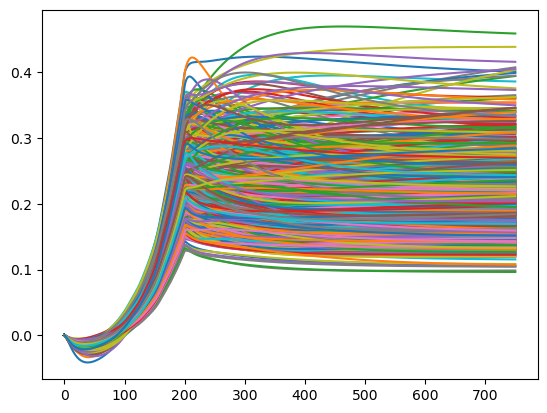

In [8]:
pl.plot(f[1950].temperature.sel(layer=0, scenario='ssp245'));

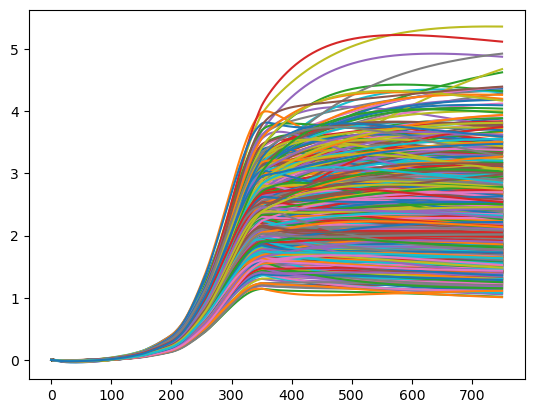

In [9]:
pl.plot(f[2100].temperature.sel(layer=0, scenario='ssp245'));

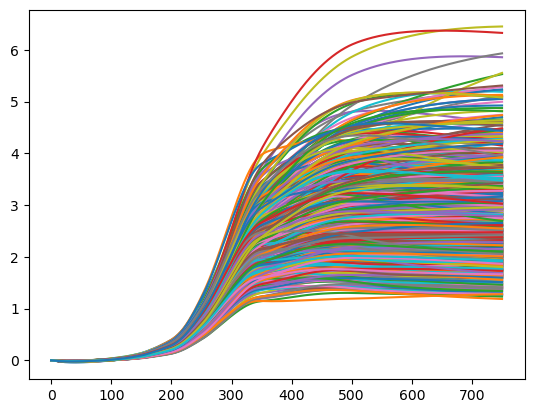

In [15]:
pl.plot(f['none'].temperature.sel(layer=0, scenario='ssp245'));

In [10]:
f[1950].temperature.sel(layer=0).shape

(751, 3, 841)

In [16]:
output = np.stack(
    (
        f['none'].temperature.sel(layer=0),
        f[1950].temperature.sel(layer=0),
        f[1955].temperature.sel(layer=0),
        f[1960].temperature.sel(layer=0),
        f[1965].temperature.sel(layer=0),
        f[1970].temperature.sel(layer=0),
        f[1975].temperature.sel(layer=0),
        f[1980].temperature.sel(layer=0),
        f[1985].temperature.sel(layer=0),
        f[1990].temperature.sel(layer=0),
        f[1995].temperature.sel(layer=0),
        f[2000].temperature.sel(layer=0),
        f[2005].temperature.sel(layer=0),
        f[2010].temperature.sel(layer=0),
        f[2015].temperature.sel(layer=0),
        f[2020].temperature.sel(layer=0),
        f[2025].temperature.sel(layer=0),
        f[2030].temperature.sel(layer=0),
        f[2035].temperature.sel(layer=0),
        f[2040].temperature.sel(layer=0),
        f[2045].temperature.sel(layer=0),
        f[2050].temperature.sel(layer=0),
        f[2055].temperature.sel(layer=0),
        f[2060].temperature.sel(layer=0),
        f[2065].temperature.sel(layer=0),
        f[2070].temperature.sel(layer=0),
        f[2075].temperature.sel(layer=0),
        f[2080].temperature.sel(layer=0),
        f[2085].temperature.sel(layer=0),
        f[2090].temperature.sel(layer=0),
        f[2095].temperature.sel(layer=0),
        f[2100].temperature.sel(layer=0),
    ),
    axis=0
)
output.shape

(32, 751, 3, 841)

In [21]:
zero_year_labels = ['none'] + [yr for yr in range(1950, 2101, 5)]

In [23]:
ds = xr.Dataset(
    data_vars = dict(
        temperature = (['zero_year', 'timebound', 'scenario', 'config'], output),
    ),
    coords = dict(
        scenario = ['ssp245', 'ssp370', 'ssp585'],
        zero_year = zero_year_labels,
        timebounds = np.arange(1750, 2500),
        config = df_configs.index
    ),
    attrs = dict(units = 'K')
)

In [24]:
ds

<xarray.Dataset> Size: 485MB
Dimensions:      (zero_year: 32, timebound: 751, scenario: 3, config: 841,
                  timebounds: 750)
Coordinates:
  * scenario     (scenario) <U6 72B 'ssp245' 'ssp370' 'ssp585'
  * zero_year    (zero_year) <U21 3kB 'none' '1950' '1955' ... '2095' '2100'
  * timebounds   (timebounds) int64 6kB 1750 1751 1752 1753 ... 2497 2498 2499
  * config       (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740
Dimensions without coordinates: timebound
Data variables:
    temperature  (zero_year, timebound, scenario, config) float64 485MB 0.0 ....
Attributes:
    units:    K

In [25]:
os.makedirs('../output/', exist_ok=True)

In [26]:
ds.to_netcdf('../output/scenario_zec.nc')